# 模拟退火解决TSP问题

姓名：李方舟

学号：2019141080002

## 模拟退火算法提出

模拟退火算法就是模拟现实中，固体分子在退火过程中，内能会自然地达到最低状态的过程。

为什么会很自然的达到能量最低状态呢？因为物体低能量状态比高能量状态更稳定，物体从高能量向低能量变化比从低能量向高能量变化要更容易。而显示中的很多问题也向固体退火一样，存在一个存在一个最优（能量最低）的解（状态），可是问题的解的分布往往不是单调的，其中存在许多的局部最优解。而模仿固体退火的过程，可以让我们跳出装卸局部最优解，并不断地找到全局更优的状态。具体原理是，在一开始让解变化的随机性变大，也就是让解从优到差的可能性变大，从而能够跳出局部最优。而随着迭代次数的增加，开始逐渐让随机性变小，让从优到差的可能性变小，从而接近全局最优。

## 实现并解决问题

具体的步骤和流程在老师上课发的讲义上已经很清楚了，因而我们要做的就是去实现一个模拟退火算法并去解决一个实际问题。

但是很可惜，在尝试用它来解决jsp（作业车间调度）问题时，我遇到了一些模拟退火算法之外的问题（后面解决了，在另一个报告中）。我没有搞懂怎么实现通过出队序列得出具体的生产调度，从而算出具体的加工时间和绘制甘特图。在之前的生产计划课程上我使用的是Lekin这样的软件自动按照规则生成gantt图，或是用现成的matlab代码。但是我认为这节课我们主要学习的是“模拟退火”的原理，而不是如何实现计算加工时间和画gantt图。所以我最后还是选择去解决比较熟悉的TSP问题来学习该算法。

一来是曾经用遗传算法实现过它，有一些经验。二是把JSP的出队序列换成这里的坐标顺序，把jsp的总时长换成这里的总距离，那么求解过程应该是一样的，二者用模拟退火求解的相似性十分高。

## 具体实现

首先引入numpy库用于矩阵运算，以及matplotlib用于画图

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### 问题
这里我随便输了几个坐标，作为要解决的TSP问题，并用matplotlib画了散点图。我尽量让点分散在一个环形上，这样优解和劣解差别比较明显。

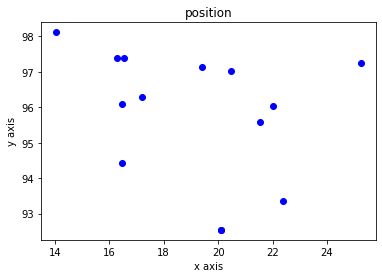

In [8]:
# solu = np.array([[2,1],
#                 [1,5],
#                 [2,8],
#                 [4,9],
#                 [7,8],
#                 [9,5],
#                 [8,2],
#                 [5,1],
#                 [4,3],
#                 [7,2.5]])

solu = np.array([[16.47, 96.10],
                 [16.47, 94.44],
                 [20.09, 92.54],
                 [22.39, 93.37],
                 [25.23, 97.24],
                 [22.00, 96.05],
                 [20.47, 97.02],
                 [17.20, 96.29],
                 [16.30, 97.38],
                 [14.05, 98.12],
                 [16.53, 97.38],
                 [21.52, 95.59],
                 [19.41, 97.13],
                 [20.09, 92.55]])

c = len(solu)

#绘图

x = solu[:,0]
y = solu[:,1]
plt.title("position") 
plt.xlabel("x axis") 
plt.ylabel("y axis")
plt.plot(x,y,"ob") 
plt.show()

### 代价函数 cost
定义函数dis用于计算某个解的总距离

In [9]:
def distence2point(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def dis(pos):
    all = 0
    for i in range(c-1):
        all = all + distence2point(pos[i],pos[i+1])
    all = all + distence2point(pos[c-1],pos[0])
    return all

### 模拟退火及邻域选择
接下来就是模拟退火算法的关键了。该函数用于找出一个邻域解，并决定是否选择。两个参数sold代表solution old，也就是旧的解；T为温度。该函数会根据这两个参数，最终返回一个新的解（可能和旧的是一样的，根据稳定按照一定概率选择）

首先创建一个sold的副本为snew。我采用的邻域算法比较简单，有两种：1是随机取两个点snew上的坐标进行交换，2是随机取一个点并与下一个点交换。这两种随机选择，我设置的概率比是1：2。接下来计算snew和sold的cost（我这里直接用总距离当作代价值，感觉对于这道题效果还可以），并根据cost之差和温度，按照讲义上的那个公式来根据概率决定返回snew还是sold。

为了统计最后每个温度平均距离的变化，我还返回了距离

In [10]:
#邻域及是否选择
def selectNew(sold, T):
    flag = np.random.randint(2)
    snew = sold.copy()
    if (flag == 0):
        a = np.random.randint(c-1)
        b = np.random.randint(c-1)
        while (b == a):
            b = np.random.randint(c-1)
    else:
        a = np.random.randint(c-2)
        b = a + 1
    
    temp = snew[a].copy()
    snew[a] = snew[b]
    snew[b] = temp
    
    dcost = dis(snew) - dis(sold)
    if (dcost < 0):
        return snew
    else:
        if (np.exp(-dcost / T) > np.random.rand()):
            return snew
        else:
            return sold

### 运行
接下来就是运行了。我这里设置的初始温度为10，衰减速率为0.95，每个温度的迭代次数为100，当温度低于0.05时结束

由于绘图用的不是很熟练，为了防止文档太长，我每隔20次温度变化输出一次解的图像，同时每个温度的100次迭代只输出4个解。

下面是具体的代码和运行结果：

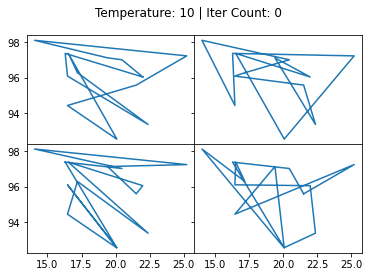

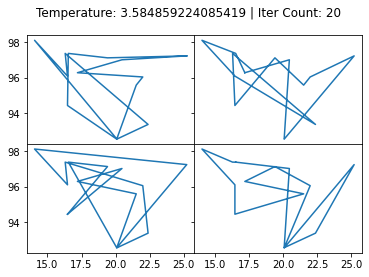

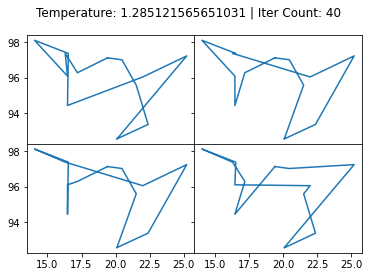

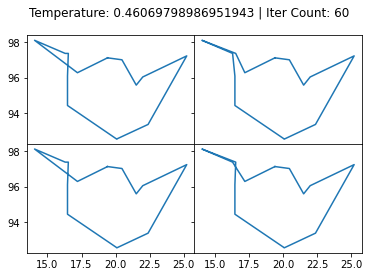

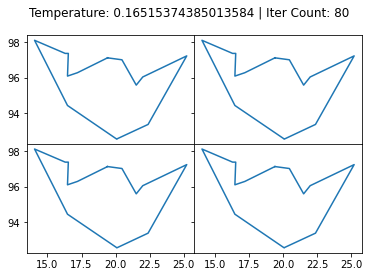

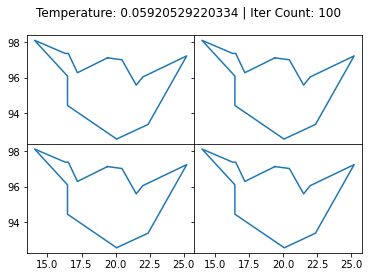

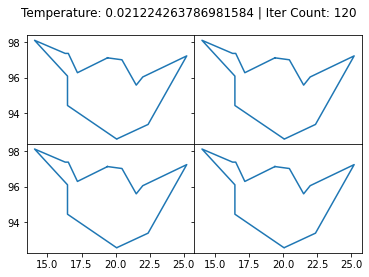

In [11]:
#初始随机解
np.random.shuffle(solu)
#初始温度 衰减速率
Temp = 10
alpha = 0.95
#每个温度迭代次数
iterCount = 100
#一个数组来存储每个温度下的平均距离
allDis = []
#用来标记总迭代次数和是否绘图
count = 0
flag = False

while(Temp > 0.01):
    
#-------------------------------绘图------------------------------------
    if (count % 20 == 0):
        fig = plt.figure()
        gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
        axs = gs.subplots(sharex='col', sharey='row')
        fig.suptitle('Temperature: ' + str(Temp) + ' | Iter Count: ' + str(count))
        flag = True
    else:
        flag = False
#--------------------------------------------------------------------------

    count += 1
    for i in range(iterCount):
        solu = selectNew(solu, Temp)

#-------------------------------绘图------------------------------------
        if (flag and i % 25 == 0):
            x = solu[:,0]
            y = solu[:,1]
            x = np.append(x, solu[0,0])
            y = np.append(y, solu[0,1])
            axs[i % 2][(i // 2) % 2].plot(x,  y)
#-------------------------------------------------------------------------
    allDis.append(dis(solu))

    Temp *= alpha

### 展示结果

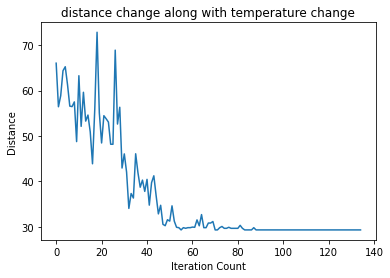

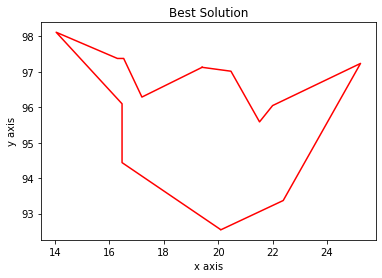

距离为29.340520066994223


In [12]:
# 距离随温度变化
x = list(range(len(allDis)))
y = allDis
plt.title("distance change along with temperature change") 
plt.xlabel("Iteration Count") 
plt.ylabel("Distance")
plt.plot(x,y) 
plt.show()

# 展示最终结果
x = solu[:,0]
y = solu[:,1]
x = np.append(x, solu[0,0])
y = np.append(y, solu[0,1])
plt.title("Best Solution") 
plt.xlabel("x axis") 
plt.ylabel("y axis")
plt.plot(x,y,"r")
plt.show()

print("距离为" + str(dis(solu)))

# 思考
在经过多次实验后，我发现并不是每一次都会收敛到全局最优解，有时候会收敛到一个十分接近全局最优的局部最优解中。我设置的参数为最高温度10，每个温度迭代100次，每次温度下降5%，收敛到0.1结束，**但是并未设置波尔兹曼常数**。因为我觉得玻尔兹曼常数带来的影响，完全可以由改变温度的区间范围来得到同样的效果。在这样的设置下我跑了许多次，并不断进行了一些微调，TSP问题绝大部分都收敛到了全局最优，JSP问题也有90%都能跑出最优解，剩下的也都是在接近全局最优的部分局部最优解中。大概总结了下面的一些经验。

### 温度设置
首先在温度设置上上从上面的TSP问题的距离随迭代变化图可以看出，大约是在第40-50次迭代时，变化逐步趋于稳定，解逐渐收敛。这个时候的温度大约是1度。而在另一个JSP问题中也是类似，在温度约为1左右开始明显收敛。因为我用的的这两个问题案例有个共同特点，就是它们的**代价值**都差不多：这个TSP问题的距在30-50离左右，而该JSP问题的最短时间也在60-80左右。此外，两个相邻的解，其代价之差dconst也很小，往往都是在1左右，例如上面的TSP问题，就很容易收敛到另一个距离为29的解中。公式(np.exp(-dcost / T)在温度为1，dcost也是1（新解比旧解劣，劣了1）时的值为0.36。这个概率就已经达到了一个分水岭：如果温度再高一点，例如5，那么概率就是0.8.就很容易得选择新的劣解；如果温度低一点，例如0.2，此时选择新解的概率是0.006，就基本趋于稳定，难以跳出局部最优了。

当温度过高时，如果选择新的劣解的概率到了90%以上，那么几乎就是在乱找，可以说没有什么规律性可言。而在温度很低时，选择新解的概率低于了0.01，就极难跳出局部最优。所以我认为，要尽量缩短前面乱找的阶段，而延长从乱找到稳定的阶段。从上面的TSP和JSP问题来看，我认为要尽量减少温度大于1的搜索，所以我把初始温度设置为10，而不是更大的100或1000。而当温度低于0.1时解几乎不再发生变化，即使陷入局部最优也极难跳出，所以我只将最低温度设置在0.1。如果要再在温度上进行改进，我也许会在温度为1左右时，增大每个温度下的迭代次数或者降低温度变化率。

### 迭代次数 温度变化率

关于每个温度的迭代次数，我认为和温度的变化率二者是互补的。如果温度的变化率变小了，例如每次设置alpha=0.99，那么就可以相应的减少迭代次数，可以从100次减小到20次。同时，越是复杂的问题迭代次数应该越多，或者温度变化率应该越小。在我选择的这两个JSP和TSP问题中，明显JSP问题的解的范围更大更复杂，因此迭代次数也应该设置的多一点，以提供更多的跳出局部最优的可能。

### 邻域选择
邻域选择我只采用了两种方式，一是随机取两个点进行交换，二是将某个点和下一个点进行交换。二者随机选择，比例为1：2。但在实际运行中，我发现这两种选择方法对收敛速度是否会陷入局部最优还是有一定的影响。

如果是将某个点与下一个点进行交换，那么解更容易收敛，但也更容易陷入局部最优。如果是随机取两个点交换，那么解就更难收敛，同时也更容易跳出局部最优。在温度低于0.5，解已经收敛了之后，依然有可能从“局部最优”变换到全局最优（因为在这种选择下，全局最优解的邻域变大了，原本的部分局部最优解也成为了全局最优解的邻域），因此在TSP问题中我最终将二者的选择比例设置为1：2。而对于另一个的JSP问题，由于解的编码长度为36，且编码方式更特殊一点，相邻取两个工序交换的意义感觉不是很大，所以我将比例设置为1：4。关于最佳的邻域选择方案我暂时还没有想好。

# 总结

我认为模拟退火算法是较为典型且简单的智能算法，通过metropolis准则，它能够在全局上不断地逼近最优解，同事以一定概率接受劣从而可以跳出局部最优。而实际运行起来，在解决TSP问题上，我感觉模拟退火算法是优于遗传算法的，首先在实现方法上就要简单相当多，而收敛速度也明显更快一点。缺点是在面对更复杂的问题时也更容易陷入局部最优。